### Model development based on demographic features, pyPPG features, and xgboost architecture

*Date:* 2025-06-19 <br> 
*Author:* salil apte  <br> 
*Version:* 1.0  <br> 
*Filename:* `04-ppg-demo-xgboost-model.ipynb`

This notebook contains the training and evaluation of a [xgboost](https://xgboost.readthedocs.io) model using the five demographic features and the [pyPPG](https://pyppg.readthedocs.io) features. The process is repeated 50 times with different training/validation splits, which are designed to not have any overlap of users.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# Load the training data
df_demo = pd.read_parquet(r"E:\repos\vital-sign-estimation\data\processed\demographics.parquet")
df_ppg = pd.read_parquet(r"E:\repos\vital-sign-estimation\data\processed\features.parquet")
labels = pd.read_csv(r"E:\repos\vital-sign-estimation\data\raw\train_labels.csv")
df = pd.concat([df_demo, df_ppg], axis=1)
df.drop(columns=["id"], inplace=True)
print(df.shape)
df.head()

(60000, 924)


,features_0,features_1,features_2,features_3,features_4,ppg_sig_Tpi_mean,ppg_sig_Tpp_mean,ppg_sig_Tsys_mean,ppg_sig_Tdia_mean,ppg_sig_Tsp_mean,...,derivs_ratios_(Ad-Ab)/Aa_mad,derivs_ratios_AGI_mad,derivs_ratios_AGImod_mad,derivs_ratios_AGIinf_mad,derivs_ratios_AI_mad,derivs_ratios_RIp1_mad,derivs_ratios_RIp2_mad,derivs_ratios_SC_mad,derivs_ratios_IPAD_mad,sqi
0,-1.251488,1.009981,0.603974,0.252646,1.949994,0.982941,0.966471,0.509412,0.430000,0.318824,...,0.592561,1.067743,0.865141,0.757950,0.075384,0.082008,0.082008,37.517409,1.051186,89.59
1,0.087479,1.475090,0.033434,0.252646,0.715404,0.773333,0.772857,0.507619,0.360000,0.380000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.715901,1.087499,0.603974,0.252646,1.209240,0.797619,0.801429,0.422857,0.341500,0.269524,...,0.580444,1.940667,1.411044,1.163904,0.099410,0.112588,0.112588,57.258783,1.183932,89.40
3,1.069389,0.002245,-1.250281,0.252646,-0.272268,0.919444,0.898889,0.571667,0.341429,0.378333,...,0.737179,1.138604,0.809375,1.504465,0.076667,0.064110,0.064110,26.846324,0.587688,93.04
4,-0.626637,0.932463,1.174513,0.252646,0.550792,0.894444,0.890000,0.375556,0.460556,0.250556,...,0.798776,0.831863,0.691418,1.657856,0.111074,0.125076,0.125076,594.855004,0.739224,68.35


In [3]:
# Prepare features, labels, and user ids
X = df.to_numpy()
y = labels.to_numpy()
unique_ids = df_demo["id"].unique()

In [4]:
# Set training and model parameters
n_bootstraps = 50
test_size = 0.2

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 5,
    "eta": 0.03,
    "subsample": 0.75,
    "colsample_bytree": 0.7,
    "reg_alpha": 3.0,
    "reg_lambda": 2.0,
    "seed": 1,
    "tree_method": "gpu_hist",  
}

In [5]:
# Define the training run
def training_run(i):
    # Split the ids for training and testing    
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=i)

    train_mask = df_demo["id"].isin(train_ids)
    test_mask = df_demo["id"].isin(test_ids)

    # Split the train and test dataset
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[test_mask], y[test_mask]

    # Create DMatrix objects
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dval = xgb.DMatrix(data=X_val, label=y_val)

    # Train model with early stopping
    evals = [(dtrain, "train"), (dval, "val")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=400,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False,
    )

    y_pred = model.predict(dval)
    mse = mean_squared_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    return {"seed": i, "mse": mse, "mape": mape}

In [6]:
# Run 50 training runs in parallel
results = Parallel(n_jobs=8)(
    delayed(training_run)(i) for i in tqdm(range(n_bootstraps))
)

100%|██████████| 50/50 [03:43<00:00,  4.46s/it]


         MSE-DPG   MAPE-DPG
count  50.000000  50.000000
mean    2.091243   2.291682
std     0.031802   0.547827
min     2.034987   1.466085
25%     2.064964   1.849808
50%     2.086546   2.234510
75%     2.111003   2.735602
max     2.183239   3.901169


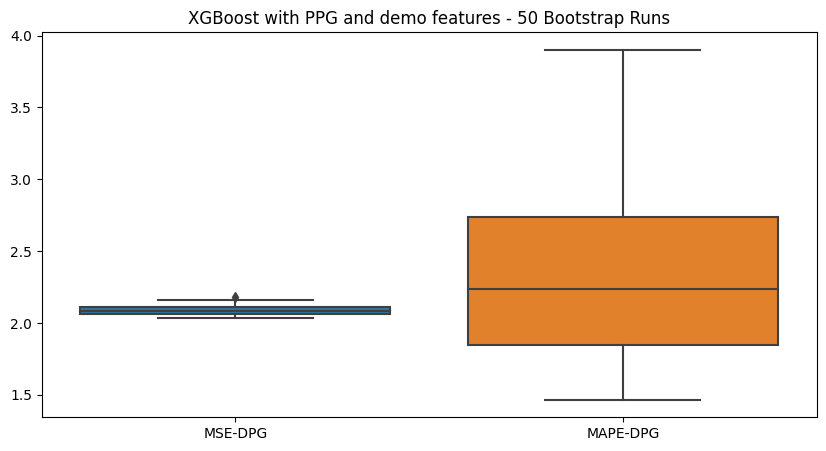

In [13]:
# Collate the results
results_df = pd.DataFrame(results)
results_df.drop(columns="seed", inplace=True)
results_df.rename(columns={'mse': 'MSE-DPG', 'mape': 'MAPE-DPG'}, inplace=True)
print(results_df.describe())
pd.DataFrame(results_df).to_csv(r"E:\repos\vital-sign-estimation\reports\results\dem_ppg.csv", index=False)

# Visualize the results
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df[["MSE-DPG", "MAPE-DPG"]])
plt.title("XGBoost with PPG and demo features - 50 Bootstrap Runs")
plt.show()